In [1]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf


### 이미지 전처리

In [2]:
IMAGE_SIZE = (300, 300)

IMAGE_PATH = "./plant-pathology-2020-fgvc7/images/"
TEST_PATH = "./plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "./plant-pathology-2020-fgvc7/train.csv"
#SUB_PATH = "./plant-pathology-2020-fgvc7/sample_submission.csv"

test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(IMAGE_PATH + file_path)
    
    # 이미지 크기 확인
    height, width, _ = image.shape

    # 이미지를 224, 224로 줄이기
    image = cv2.resize(image, IMAGE_SIZE)

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

images = train_data["image_id"][:].apply(load_image)



In [3]:
images = np.stack(images)
labels = train_data[["healthy", "multiple_diseases", "rust", "scab"]].values

In [14]:
BATCH_SIZE = 4
LEARNING_RATE = 0.00025
K_NUM= 3

from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3
efmodel = EfficientNetV2B3(include_top=False, weights='imagenet', input_shape= (IMAGE_SIZE[1], IMAGE_SIZE[0], 3))
model = Sequential()
model.add(efmodel)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='leaky_relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 10, 10, 1536)     12930622  
 al)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 153600)            0         
                                                                 
 dropout_4 (Dropout)         (None, 153600)            0         
                                                                 
 dense_5 (Dense)             (None, 64)                9830464   
                                                                 
 dense_6 (Dense)             (None, 4)                 260       
                                                                 
Total params: 22,761,346
Trainable params: 22,652,130
Non-trainable params: 109,216
____________________________________

In [17]:
y_categorical = np.argmax(labels, axis=1)
k = 5  # Number of folds
stratified_kfold = StratifiedKFold(n_splits=k)

history = None
for i, (train_indices, test_indices) in enumerate(stratified_kfold.split(images, y_categorical)):
    if i != K_NUM:
        continue
        
    train_images, val_images = images[train_indices], images[test_indices]
    train_labels, val_labels = labels[train_indices], labels[test_indices]

    train_datagen = ImageDataGenerator(
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=5,
                                   #shear_range=0.7,
                                   #zoom_range=[0.9, 2.2],
                                   shear_range=0.2,
                                   zoom_range=[0.9, 1.1],
                                   fill_mode='nearest'
                                   )

    val_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(x=train_images, y=train_labels, batch_size=BATCH_SIZE, shuffle=True)
    val_generator = train_datagen.flow(x=val_images, y=val_labels, batch_size=BATCH_SIZE, shuffle=True)
    
    modelpath = f'./model/train10/kfold{i}/'
    modelname = 'epoch{epoch}.hdf5'
    checkpointer = ModelCheckpoint(filepath=modelpath+modelname, monitor='val_loss', verbose=1, save_freq='epoch')
    #early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(train_generator, epochs=100, verbose=1, callbacks=[checkpointer], validation_data=val_generator)

Epoch 1/100
365/365 [==============================] - ETA: 0s - loss: 1.2227 - accuracy: 0.7358
Epoch 1: saving model to ./model/train10/kfold3\epoch1.hdf5
365/365 [==============================] - 39s 81ms/step - loss: 1.2227 - accuracy: 0.7358 - val_loss: 0.3268 - val_accuracy: 0.9121
Epoch 2/100
365/365 [==============================] - ETA: 0s - loss: 0.6118 - accuracy: 0.8298
Epoch 2: saving model to ./model/train10/kfold3\epoch2.hdf5
365/365 [==============================] - 29s 79ms/step - loss: 0.6118 - accuracy: 0.8298 - val_loss: 0.3273 - val_accuracy: 0.9121
Epoch 3/100
365/365 [==============================] - ETA: 0s - loss: 0.4829 - accuracy: 0.8668
Epoch 3: saving model to ./model/train10/kfold3\epoch3.hdf5
365/365 [==============================] - 30s 82ms/step - loss: 0.4829 - accuracy: 0.8668 - val_loss: 0.5644 - val_accuracy: 0.8187
Epoch 4/100
365/365 [==============================] - ETA: 0s - loss: 0.4606 - accuracy: 0.8785
Epoch 4: saving model to ./model/

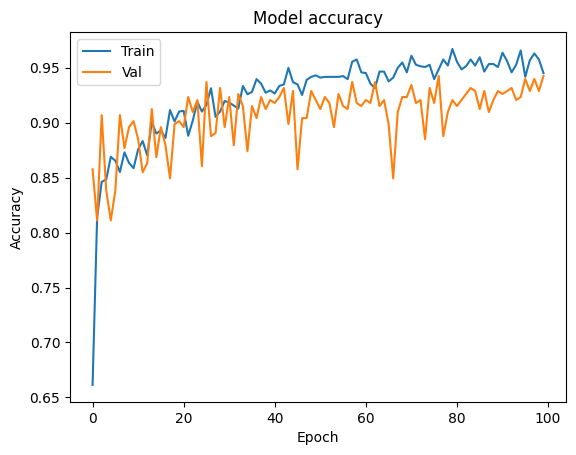

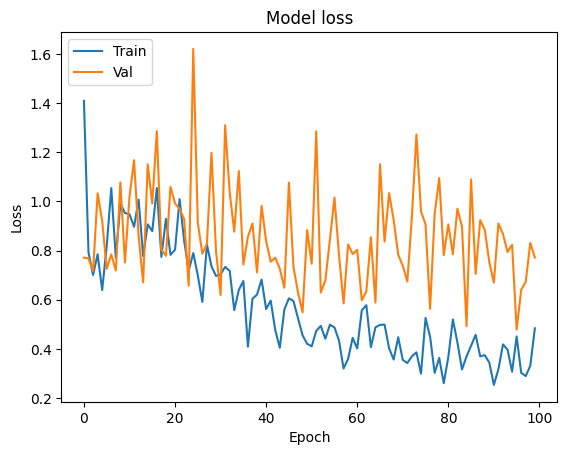

In [7]:
#fold0

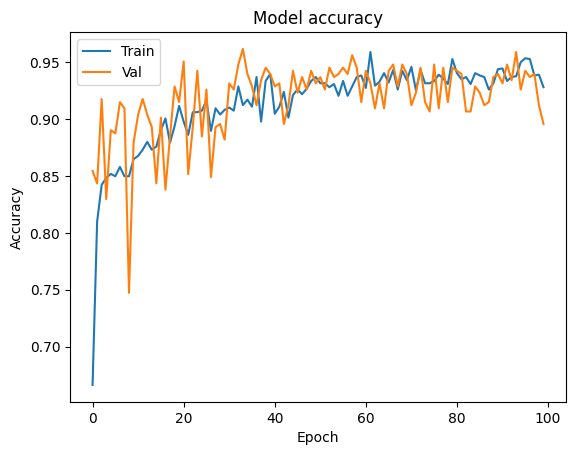

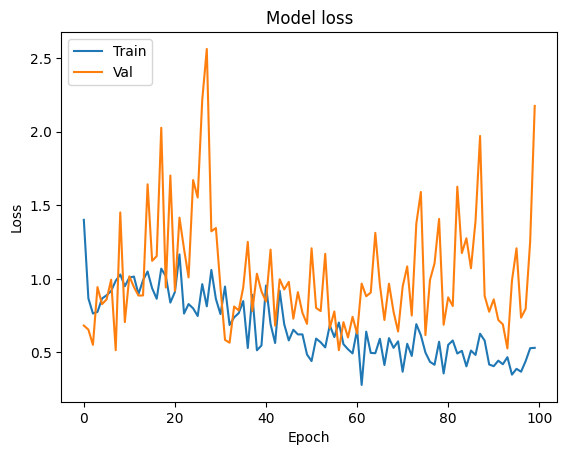

In [13]:
#fold1

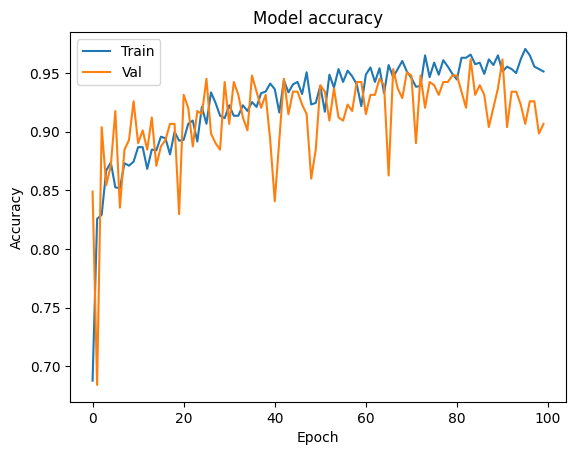

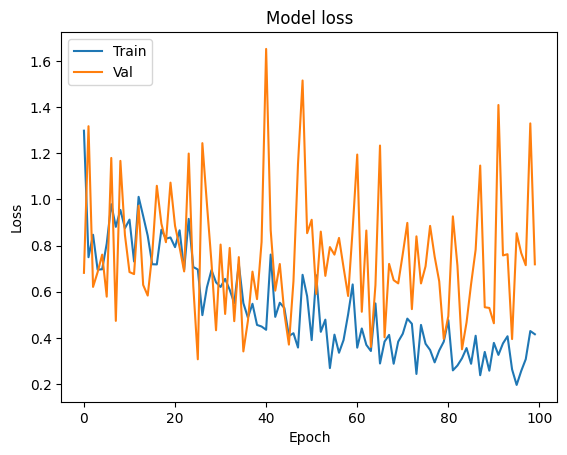

In [12]:
#fold2

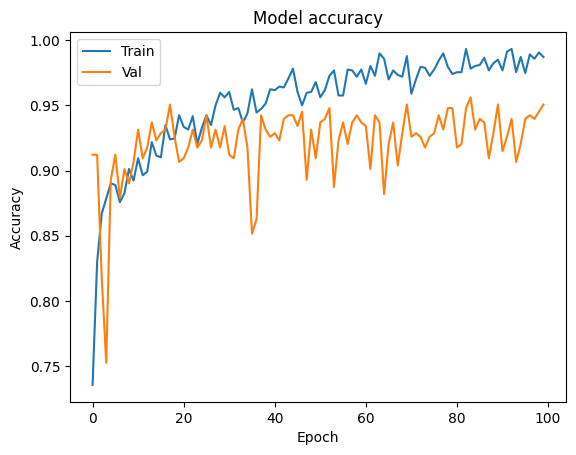

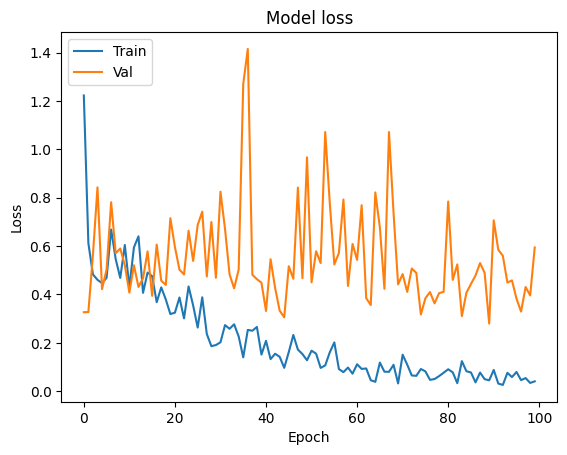

In [18]:
#fold3
# 6 훈련 과정 시각화 (정확도)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
#fold
# 6 훈련 과정 시각화 (정확도)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
#우려내기 테스트

y_categorical = np.argmax(labels, axis=1)
k = 5  # Number of folds
stratified_kfold = StratifiedKFold(n_splits=k)

history = None
for i, (train_indices, test_indices) in enumerate(stratified_kfold.split(images, y_categorical)):
    if i != K_NUM:
        continue
        
    train_images, val_images = images[train_indices], images[test_indices]
    train_labels, val_labels = labels[train_indices], labels[test_indices]

    train_datagen = ImageDataGenerator(
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=5,
                                   #shear_range=0.7,
                                   #zoom_range=[0.9, 2.2],
                                   shear_range=0.2,
                                   zoom_range=[0.9, 1.1],
                                   fill_mode='nearest'
                                   )

    val_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(x=train_images, y=train_labels, batch_size=BATCH_SIZE, shuffle=True)
    val_generator = train_datagen.flow(x=val_images, y=val_labels, batch_size=BATCH_SIZE, shuffle=True)
    
    modelpath = f'./model/train10/kfold{i}_start101/'
    modelname = 'epoch{epoch}.hdf5'
    checkpointer = ModelCheckpoint(filepath=modelpath+modelname, monitor='val_loss', verbose=1, save_best_only=True)
    #early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(train_generator, epochs=100, verbose=1, callbacks=[checkpointer], validation_data=val_generator)

In [ ]:
# 6 훈련 과정 시각화 (정확도)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
